# SIR modelling as in: Data-driven approaches for predicting spread of infectious diseases through DINNs: Disease Informed Neural Networks

Notes for self:
SIR stands for 
- Susceptible
- Infective
- Removed (recovered)

S -> I -> R
The transfer rate from S->I is beta. Called transmission rate.
The transfer rate from I->R is alpha. Called recovery rate.

The system of ODE with the 3 variables is as follows. All variables are functions of time t:
dS/dt = -beta * S * I
dI/dt = beta * S * I - alpha * I
dR/dt = alpha I

Assumed that no one has recovered at the onset: 
R(0) = 0
Initial number of Infected is I(0) = I_0

## How DINN's are trained
1. The ODE's are solved with known initial conditions and true parameters (I think they mean alpha, beta etc.).
    This step results in a data series of S, I, R for each t. They use 50-100 points.
    They restrict the parameters around the true values. Not stated by how much.
2. For this set of data points we train using loss from
    - Data point loss
    - ODE loss

Note: I am a unsure how they obtain the parameters alpha beta from the network. They train the network to take in a time t and
output a S, I, R. How does this result in an alpha/beta etc.


In [1]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
#from torchvision.datasets import MNIST
from timeit import default_timer as tdt

#from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'
    
has_been_run = True

In [2]:
# Time setup
n_days = 1000
t = np.arange(0, n_days+1, 1)

## Disease setup
alpha = 0.01
beta = 0.025

# Initial conditions
N = 1000.0   # Population size
I0 = 100.0/N      # Initial number of infected
R0 = 0.0/N      # Initial number of recovered
S0 = 1 - I0 - R0    # Initial number of susceptible

# Solving the system numerically 

In [3]:
# Solve numerically
def SIR_model_num(t, y, N, beta, alpha):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - alpha * I
    dRdt = alpha * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0, I0, R0]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t[0], t[-1]], y0, args=(N/N, beta, alpha), t_eval=t, method='LSODA')

S_data = sol.y[0]
I_data = sol.y[1]
R_data = sol.y[2]
print(sol.message)

The solver successfully reached the end of the integration interval.


Text(0.5, 1.0, 'Numerical Solution to SIR model')

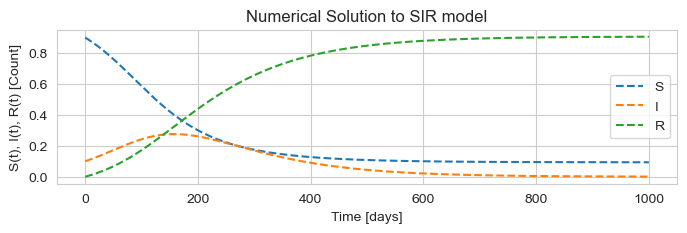

In [4]:
# Plot numerical solution
fig, ax = plt.subplots(1, 1, figsize=(8,2))
ax.plot(t, S_data, linestyle='--', label='S')
ax.plot(t, I_data, linestyle='--', label='I')
ax.plot(t, R_data, linestyle='--', label='R')

ax.set_xlabel('Time [days]')
ax.set_ylabel('S(t), I(t), R(t) [Count]')
ax.legend()
ax.set_title('Numerical Solution to SIR model')

# Training a neural network to solve the ODE system
In the following I will setup a network for solving the system of ODE's (SIR model).
I will assume we know beta and alpha here which is of course cheating. The idea is to figure out what 
network size we need in order to capture the dynamics.
## Description
### Loss functions
Two loss functions will be implemented at first
1. The ODE loss
2. The initial condition loss
Later loss based on data points will be implemented
### Network structure
The input for the network will be time t.
The output of the network will be U. 
where
S = U[0]
I = U[1]
R = U[2]

In [5]:
# ================== Loss functions ==================
# Defining loss function for reasons unknown
torch_MSE_loss = torch.nn.MSELoss()

# Loss for the ODE
def get_loss_ODE(net, t, alpha, beta):
    # Find network solution
    U = net(t)
    S = U[:,0]
    I = U[:,1]
    R = U[:,2]
    
    # Calculate derivatives
    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0].squeeze()
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0].squeeze()
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0].squeeze()
    
    # Calculate loss
    # Error1:
    rhs_S = -beta * S * I
    loss1 = torch_MSE_loss(dSdt, rhs_S)
    # Error2:
    rhs_I = beta * S * I - alpha * I
    loss2 = torch_MSE_loss(dIdt, rhs_I)
    # Error3:
    rhs_R = alpha * I
    loss3 = torch_MSE_loss(dRdt, rhs_R)
    
    # Summing the loss. Consider returning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3
    
    return loss_total

# Loss for the initial condition
def get_loss_IC(net, t0, S0, I0, R0):
    # Find network solution
    U = net(t0).view(1,-1)   # reshape as there is only 1 time "t".
    S0_net = U[:,0]
    I0_net = U[:,1]
    R0_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S0, S0_net)
    loss2 = torch_MSE_loss(I0, I0_net)
    loss3 = torch_MSE_loss(R0, R0_net)
    
    # Summing the loss. Consider retutning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3 
    
    return loss_total

def get_data_point_loss(net, t_data, S_data, I_data, R_data):
    # Find network solution
    U = net(t_data.view(-1,1))   # reshape as there is only 1 time "t".
    S_net = U[:,0]
    I_net = U[:,1]
    R_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S_net, S_data)
    loss2 = torch_MSE_loss(I_net, I_data)
    loss3 = torch_MSE_loss(R_net, R_data)
    
    loss_total = loss1 + loss2 + loss3
    
    return loss_total
    

In [6]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0])
        self.L2 = nn.Linear(HL[0], HL[1])
        self.L3 = nn.Linear(HL[1], HL[2])
        self.L4 = nn.Linear(HL[2], HL[3])
        self.L5 = nn.Linear(HL[3], HL[4])
        self.L6 = nn.Linear(HL[4], HL[5])
        self.L7 = nn.Linear(HL[5], HL[6])
        self.L8 = nn.Linear(HL[6], HL[7])
        self.output = nn.Linear(HL[-1], output_size)
        
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        x = self.act_fn(self.L4(x))
        x = self.act_fn(self.L5(x))
        x = self.act_fn(self.L6(x))
        x = self.act_fn(self.L7(x))
        x = self.act_fn(self.L8(x))

        # Output layer
        x = self.output(x)
        
        return x

    
# Define network
net = FFN(1, [32,32,32,32,32,32,32,32], 3).to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test the network
print(net(torch.tensor(1.0, device=my_device).view(-1,1)))


<bound method Module.parameters of FFN(
  (L1): Linear(in_features=1, out_features=32, bias=True)
  (L2): Linear(in_features=32, out_features=32, bias=True)
  (L3): Linear(in_features=32, out_features=32, bias=True)
  (L4): Linear(in_features=32, out_features=32, bias=True)
  (L5): Linear(in_features=32, out_features=32, bias=True)
  (L6): Linear(in_features=32, out_features=32, bias=True)
  (L7): Linear(in_features=32, out_features=32, bias=True)
  (L8): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=3, bias=True)
  (act_fn): Tanh()
)>
tensor([[-0.0810, -0.2189,  0.1888]], grad_fn=<AddmmBackward0>)


In [7]:
# ================== Testing the loss functions ==================
t_test = torch.linspace(0, 1000, 1001, device=my_device, requires_grad=True).view(-1,1)
t0 = torch.tensor([0.0], device=my_device)

# Converting initial conditions for torch formatting
S0 = torch.tensor([S0], device=my_device)
I0 = torch.tensor([I0], device=my_device)
R0 = torch.tensor([R0], device=my_device)
print(f'Initial Conditions: S0: {S0}, I0: {I0}, R0: {R0}')

# Testing ODE loss
loss_ODE = get_loss_ODE(net, t_test, alpha, beta)
print(loss_ODE)

# Testing IC loss
loss_IC = get_loss_IC(net, t0, S0, I0, R0)
print(loss_IC)

# Move data points to device
if has_been_run:
    t_data = torch.tensor(t, device=my_device, dtype=torch.float32)
    S_data = torch.tensor(S_data, device=my_device, dtype=torch.float32)
    I_data = torch.tensor(I_data, device=my_device, dtype=torch.float32)
    R_data = torch.tensor(R_data, device=my_device, dtype=torch.float32)
has_been_run = False
# Testing data loss
loss_data = get_data_point_loss(net, t_test, S_data, I_data, R_data)
print(loss_data)

Initial Conditions: S0: tensor([0.9000]), I0: tensor([0.1000]), R0: tensor([0.])
tensor(1.3180e-05, grad_fn=<AddBackward0>)
tensor(1.0951, grad_fn=<AddBackward0>)
tensor(0.5752, grad_fn=<AddBackward0>)


### Training the network on the losses

In [8]:
# Loss saving
loss_saved, loss_ODE_saved, loss_IC_saved = [], [], []
#adapt_ode_loss_saved, adapt_IC_loss_saved = [], []
epochs_saved = [0]
# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4) #, weight_decay=1e-4

#setup softadapt
lambda_ode = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_ic = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_data = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))

optimizer_ode = optim.Adam([lambda_ode], lr=learning_rate)
optimizer_ic = optim.Adam([lambda_ic], lr=learning_rate)
optimizer_data = optim.Adam([lambda_data], lr=learning_rate)

In [9]:
# Training setup
num_epochs = 5000
save_every_epochs = 100
points_per_epoch = 1000

loss1, loss2, loss3 = [], [], []
net = net.to(my_device)
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Sample t, lambda in domain
    t_samples = torch.linspace(0, 1000, points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    #t_samples = 1000 * torch.rand(points_per_epoch, device=my_device, requires_grad=True).view(-1,1)
    
    # Calculate loss
    loss_ODE = get_loss_ODE(net, t_samples, alpha, beta)
    loss_IC = get_loss_IC(net, t_samples[0,0].view(-1,1), S0, I0, R0)
    loss_data = get_data_point_loss(net, t_data[0:200:25], S_data[0:200:25], I_data[0:200:25], R_data[0:200:25])

    loss1.append( loss_ODE )
    loss2.append( loss_IC )
    loss3.append( loss_data )
    
    loss = lambda_ode * loss_ODE + lambda_ic * loss_IC + lambda_data * loss_data
    #loss = lambda_data * loss_data + lambda_ic * loss_IC
    #loss = adapt_weights[0] * loss_ODE + adapt_weights[1] * loss_IC + adapt_weights[2] * loss_data
    #loss = loss_ODE + loss_IC + loss_data
    #loss = loss_IC
    #loss = loss_data
    
    loss.backward()
    
    #maximize gradients of lambdas by inverting the gradient
    with torch.no_grad():
        lambda_ode.grad *= -1
        lambda_ic.grad *= -1
        lambda_data.grad *= -1
    
    optimizer.step()
    optimizer_ode.step()
    optimizer_ic.step()
    optimizer_data.step()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:5}, Loss: {loss.item():9.5f}, ode_loss: {loss_ODE:7.7f}, ic_loss: {loss_IC:7.7f}, data_loss: {loss_data:7.7f}"
                f", aw_ode: {lambda_ode.item():3.2f}, aw_ic: {lambda_ic.item():3.2f}, aw_data: {lambda_data.item():3.2f}")
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        loss_ODE_saved.append(loss_ODE.detach().to('cpu'))
        loss_IC_saved.append(loss_IC.detach().to('cpu'))
        #adapt_ode_loss_saved.append( adapt_weights[0]*loss_ODE.detach().to('cpu') )
        #adapt_IC_loss_saved.append( adapt_weights[1]*loss_IC.detach().to('cpu') )


Epoch     1, Loss:   1.85544, ode_loss: 0.0000132, ic_loss: 1.0950691, data_loss: 0.7603534, aw_ode: 1.00, aw_ic: 1.00, aw_data: 1.00
Epoch   100, Loss:   0.06260, ode_loss: 0.0000212, ic_loss: 0.0063625, data_loss: 0.0556837, aw_ode: 1.02, aw_ic: 1.01, aw_data: 1.01
Epoch   200, Loss:   0.03438, ode_loss: 0.0000433, ic_loss: 0.0000097, data_loss: 0.0339758, aw_ode: 1.06, aw_ic: 1.01, aw_data: 1.01
Epoch   300, Loss:   0.02243, ode_loss: 0.0000251, ic_loss: 0.0001414, data_loss: 0.0220084, aw_ode: 1.09, aw_ic: 1.01, aw_data: 1.01
Epoch   400, Loss:   0.00253, ode_loss: 0.0000100, ic_loss: 0.0000990, data_loss: 0.0023885, aw_ode: 1.11, aw_ic: 1.01, aw_data: 1.01
Epoch   500, Loss:   0.00069, ode_loss: 0.0000114, ic_loss: 0.0000299, data_loss: 0.0006428, aw_ode: 1.12, aw_ic: 1.01, aw_data: 1.01
Epoch   600, Loss:   0.00060, ode_loss: 0.0000115, ic_loss: 0.0000256, data_loss: 0.0005499, aw_ode: 1.13, aw_ic: 1.01, aw_data: 1.01
Epoch   700, Loss:   0.00052, ode_loss: 0.0000113, ic_loss: 0.

In [10]:
print(net(t0))

tensor([8.9979e-01, 1.0011e-01, 4.0860e-04], grad_fn=<AddBackward0>)


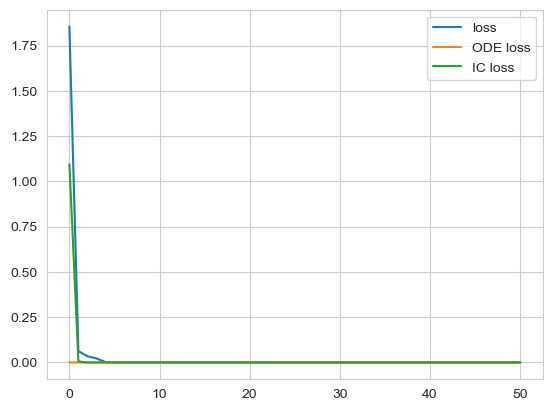

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_saved, label='loss')
ax.plot(loss_ODE_saved, label='ODE loss')
ax.plot(loss_IC_saved, label='IC loss')
ax.legend()

Text(0.5, 1.0, 'Numerical Solution to SIR model')

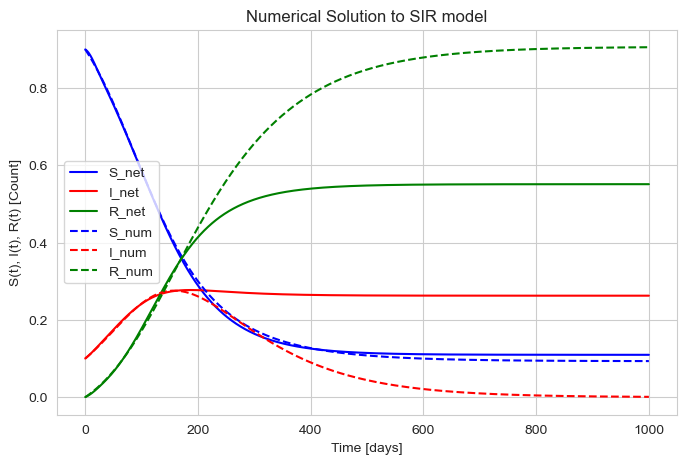

In [12]:
net_cpu = net.to('cpu')

U = net_cpu(torch.tensor(t).float().view(-1,1))
S_net = U[:,0]
I_net = U[:,1]
R_net = U[:,2]

# Plot numerical solution
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(t, S_net.detach().numpy(), linestyle='-', label='S_net', color='blue')
ax.plot(t, I_net.detach().numpy(), linestyle='-', label='I_net', color='red')
ax.plot(t, R_net.detach().numpy(), linestyle='-', label='R_net', color='green')
ax.plot(t, S_data.clone().to('cpu'), linestyle='--', label='S_num', color='blue')
ax.plot(t, I_data.clone().to('cpu'), linestyle='--', label='I_num', color='red')
ax.plot(t, R_data.clone().to('cpu'), linestyle='--', label='R_num', color='green')

ax.set_xlabel('Time [days]')
ax.set_ylabel('S(t), I(t), R(t) [Count]')
ax.legend() 
ax.set_title('Numerical Solution to SIR model')


In [13]:
# check stuff using numpy and gradient
S_net_np = S_net.detach().numpy()
I_net_np = I_net.detach().numpy()
R_net_np = R_net.detach().numpy()

# Running the sdfh nioa
dSdt = np.gradient(S_net_np)
dIdt = np.gradient(I_net_np)
dRdt = np.gradient(R_net_np)

rhs_S = beta * S_net_np * I_net_np
rhs_I = -beta * S_net_np * I_net_np + alpha * I_net_np
rhs_R = -alpha * I_net_np

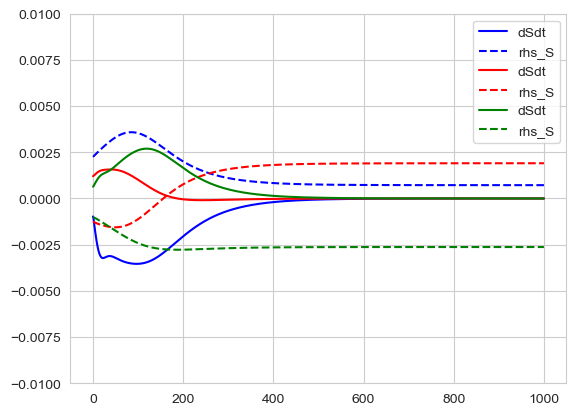

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(dSdt, color='blue', linestyle='-', label='dSdt')
ax.plot(rhs_S, color='blue', linestyle='--', label='rhs_S')
ax.plot(dIdt, color='red', linestyle='-', label='dSdt')
ax.plot(rhs_I, color='red', linestyle='--', label='rhs_S')
ax.plot(dRdt, color='green', linestyle='-', label='dSdt')
ax.plot(rhs_R, color='green', linestyle='--', label='rhs_S')
ax.set_ylim(-0.01, 0.01)
ax.legend()